<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/Mock_lenses_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install corner
_=!pip install numpyro==0.6.0 
_=!pip install pyFFTW
_=!pip install powerbox

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline


# Basic imports
import numpy as np
from scipy.optimize import minimize
from scipy.stats import spearmanr
from copy import deepcopy

#requirements
from jax.config import config
config.update("jax_enable_x64", True)
import corner
import numpyro

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.GaussianRandomField.GRF_model import Potential_based_GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.Lens_Source_model import Lens_Source_model

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18

In [39]:

#Father class. Descendants are defined by how we define Power spectrum amplitude.
#By potential variance, by deflection variance or by the PS amplitude itself
class GRF_perturbed_lens:
  #Here I fix parameters of the power spectrum, pixel grid, source light, lens light and lens mass
  def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):

    self.Lens_Source_model=Lens_Source_model(kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)
    

    #Power spectrum of the potential is PS=A*k^(-beta)
    if np.isin(np.array([Power_slope,Variance]).dtype,['float64','int64']):
      self.Variance=Variance
      self.beta=Power_slope
    else:
      raise ValueError('Wrong arguments data types. npix,pix_scl,beta,Variance,generation_seed should be numbers, so either int or float')

    #Initialize the values. They will be changed further
    self.PS_Amplitude=Variance
    #Adjust power spectrum and kwargs_lens_mass according to Variance and Power slope
    self.Change_Power_Spectrum(Variance=self.Variance,Power_slope=self.beta)


  #sum(P(k) * dk_x * dk_y)=variance is different for potential and deflection
  def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      if Variance is not None:
        self.Variance=Variance
      if Power_slope is not None:
        self.beta=Power_slope

      

      #Renew power spectrum amplitude
      npix=self.Lens_Source_model.kwargs_pixel['nx']
      pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
      #2*pi*number_pix*pix_scale
      box_length = 2 * np.pi * npix * pix_scl

      #Actually, the amplitude can be calculated from relation sum(P(k) * dk_x * dk_y)=variance
      #But here we just rescale the field from A=1 to not mess with it
      potential_field=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()
      self.PS_Amplitude=self.Variance/potential_field.var()

      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      print(new_kwargs_lenses)
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)

  
  def get_GRF_potential(self):

    npix=self.Lens_Source_model.kwargs_pixel['nx']
    pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
    #2*pi*number_pix*pix_scale
    box_length = 2 * np.pi * npix * pix_scl

    return pbox.PowerBox(N=npix, dim=2, pk=(lambda k: self.PS_Amplitude * k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()


# Prior Distributions extremes

In [9]:
lens_source_class=Lens_Source_model()
percentiles=[0.01,0.5,0.99]

## Lens extremes

In [10]:
SIE_extremes=pd.DataFrame(index=['theta_E', 'lens_q', 'lens_angle', 'center_x', 'center_y'],columns=[str(x) for x in percentiles])
for param_name in tqdm(SIE_extremes.index):
  for j in range(3):
    SIE_extremes.loc[param_name].iloc[j]=lens_source_class.init_arg(param_name,'SIE',percentiles[j])
SIE_extremes

100%|██████████| 5/5 [00:00<00:00, 191.77it/s]


,0.01,0.5,0.99
theta_E,0.867365,1.1,1.33263
lens_q,0.351048,0.7,1.04895
lens_angle,-1.53938,0,1.53938
center_x,-0.162844,0,0.162844
center_y,-0.162844,0,0.162844


WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


  0%|          | 0/5 [00:00<?, ?it/s]

theta_E


 20%|██        | 1/5 [00:02<00:11,  2.87s/it]

lens_q


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

lens_angle


 60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

center_x


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

center_y


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


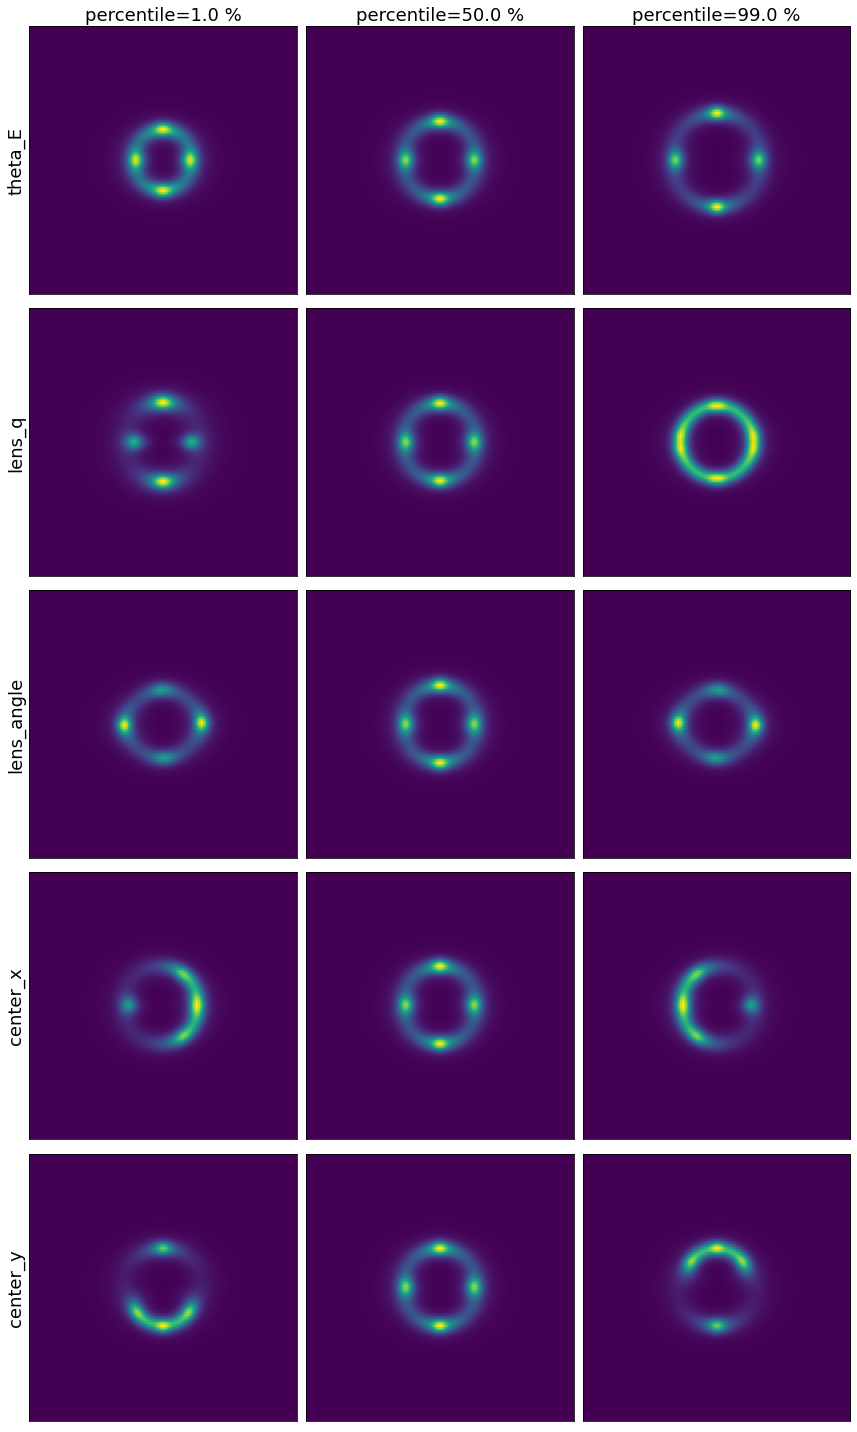

In [11]:
lens_source_class.change_source_light({'amp': 10.},arbitrary_kwargs_percentile=0.5)

fig,ax=plt.subplots(len(SIE_extremes.index),3,figsize=(12,20))
kwargs=dict()
for i in tqdm(range(len(SIE_extremes.index))):
  kwargs[SIE_extremes.iloc[i].name]=SIE_extremes.iloc[i,1]




for i in tqdm(range(len(SIE_extremes.index))):
  print(SIE_extremes.iloc[i].name)
  for j in range(3):
    varied_kwargs=deepcopy(kwargs)
    varied_kwargs[SIE_extremes.iloc[i].name]=SIE_extremes.iloc[i,j]
    lens_source_class.change_lens_mass(varied_kwargs,arbitrary_kwargs_percentile=0.5)

    image=lens_source_class.get_lens_picture(lens_mass_list=['SIE','SHEAR'])
    ax[i,j].imshow(image,origin='lower')
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

for i in range(len(SIE_extremes.index)):
  ax[i,0].set_ylabel(SIE_extremes.index[i], fontsize=FS)

for j in range(3):
        ax[0,j].set_title('percentile={:.1f} %'.format(percentiles[j]*100), fontsize=FS)

fig.tight_layout()
plt.show()

## Source extremes

In [12]:
Sersic_extremes=pd.DataFrame(index=['R_sersic', 'n_sersic', 'source_q', 'source_angle','center_x', 'center_y'],columns=[str(x) for x in percentiles])
for param_name in tqdm(Sersic_extremes.index):
  for j in range(3):
    Sersic_extremes.loc[param_name].iloc[j]=lens_source_class.init_arg(param_name,'SERSIC',percentiles[j])
Sersic_extremes

100%|██████████| 6/6 [00:00<00:00, 150.67it/s]


,0.01,0.5,0.99
R_sersic,0.233683,0.35,0.466317
n_sersic,1.83683,3,4.16317
source_q,0.367365,0.6,0.832635
source_angle,-1.53938,0,1.53938
center_x,-0.196,0,0.196
center_y,-0.196,0,0.196


  0%|          | 0/6 [00:00<?, ?it/s]

R_sersic


 17%|█▋        | 1/6 [00:02<00:14,  2.85s/it]

n_sersic


 33%|███▎      | 2/6 [00:05<00:11,  2.85s/it]

source_q


 50%|█████     | 3/6 [00:08<00:08,  2.83s/it]

source_angle


 67%|██████▋   | 4/6 [00:11<00:05,  2.82s/it]

center_x


 83%|████████▎ | 5/6 [00:14<00:02,  2.82s/it]

center_y


100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


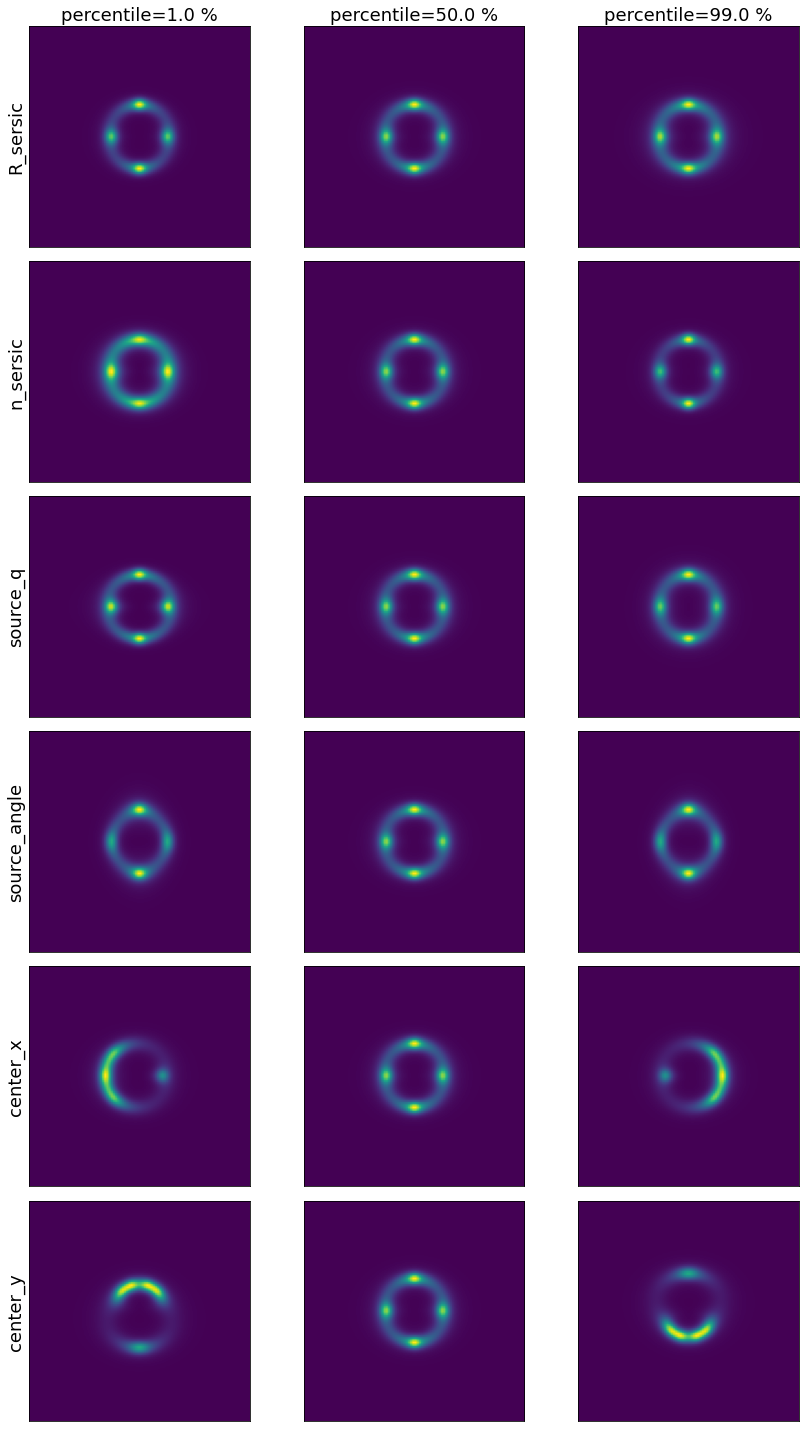

In [13]:
lens_source_class.change_source_light({'amp': 10.},arbitrary_kwargs_percentile=0.5)
lens_source_class.change_lens_mass({'theta_E': None},arbitrary_kwargs_percentile=0.5)


fig,ax=plt.subplots(len(Sersic_extremes.index),3,figsize=(12,20))
kwargs=dict()
for i in tqdm(range(len(Sersic_extremes.index))):
  kwargs[Sersic_extremes.iloc[i].name]=Sersic_extremes.iloc[i,1]




for i in tqdm(range(len(Sersic_extremes.index))):
  print(Sersic_extremes.iloc[i].name)
  for j in range(3):
    varied_kwargs=deepcopy(kwargs)
    varied_kwargs[Sersic_extremes.iloc[i].name]=Sersic_extremes.iloc[i,j]
    lens_source_class.change_source_light(varied_kwargs,arbitrary_kwargs_percentile=0.5)

    image=lens_source_class.get_lens_picture()
    ax[i,j].imshow(image,origin='lower')
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

for i in range(len(Sersic_extremes.index)):
  ax[i,0].set_ylabel(Sersic_extremes.index[i], fontsize=FS)

for j in range(3):
        ax[0,j].set_title('percentile={:.1f} %'.format(percentiles[j]*100), fontsize=FS)

fig.tight_layout()
plt.show()

In [12]:
lens_source_class.init_arg('center_x','SERSIC',0.5)

-0.1

In [17]:
import scipy.stats as stats
stats.uniform(loc=-np.pi/2,scale=np.pi).ppf(0.5)

0.0

## Shear extremes

In [ ]:
kwargs_source_light_array=[{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]
kwargs_lens_mass_array=[{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                                                                {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]
                                                                
GRF_class=Potential_based_GRF_perturbed_lens(Variance=0,Power_slope=3,SNR=100,\
                                             kwargs_source_light_array=kwargs_source_light_array,\
                                             kwargs_lens_mass_array=kwargs_lens_mass_array)

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


### Mask

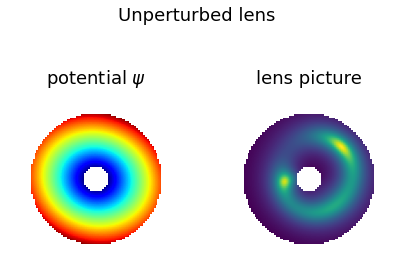

In [ ]:
#Data grid
pixel_grid = PixelGrid(**GRF_class.Lens_Source_model.kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates


#Since SIE characterisitics diverge in the center we compute everything in the masked region
# Generate a mask
rmin = 0.5
rmax = 3
# High-res grid
radius = np.hypot(xgrid, ygrid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for variance only in the masked region impacting the source's light
unperturbed_potential=deepcopy(np.array(GRF_class.get_total_potential(include_GRF=False)))
unperturbed_potential[~mask]=np.nan
unpert_potential_variance=np.nanstd(unperturbed_potential)**2

lens_picture=np.where(mask,GRF_class.get_lens_picture(picture_type='model',include_GRF=False),np.nan)

fig,ax=plt.subplots(1,2,figsize=(7,5))
ax[0].imshow(unperturbed_potential,cmap='jet', origin='lower')
ax[1].imshow(lens_picture,origin='lower')

unpert_fig_titles=[r"potential $\psi$",'lens picture']
for i in range(2):
  ax[i].axis('off')
  ax[i].set_title(unpert_fig_titles[i], fontsize=FS)

fig.suptitle('Unperturbed lens',fontsize=FS)
plt.show()

In [ ]:
df_coef=pd.DataFrame(data=[-0.1534,1.0020,-0.2656],index=['bias','potential_logvariance','beta'],columns=['Residual coefs'])
unperturbed_lens_variance=GRF_class.get_lens_picture(picture_type='model',include_GRF=False).std()**2